# Elevator Simulation

<h2>DATA604 - Final Project</h2>

<h3>Mohamed Thasleem, Kalikul Zaman</h3>

<h3>Overview</h3>

<h3>Flow-Chart</h3>

<h3>Process</h3>

In [10]:
from enum import Enum
import random
import simpy
import numpy as np
import pandas as pd
from matplotlib.pylab import plt #load plot library
# indicate the output of plotting function is printed to the notebook
%matplotlib inline 

In [11]:
LIFT_DOOR_MOVEMENT_DOOR = 3  # seconds
LIFT_HOW_MUCH_DOORS_OPEN = 6  # seconds
LIFT_SECONDS_NA_FIRST_AND_LAST_Floor = 4  # seconds, travel time of the first and last floor (longer due to acceleration / deceleration)
LIFT_SECONDS_NA_Floor = 4  # seconds, travel time of one floor
LIFT_Maximum_PASSENGERS = 12
LIFT_NUMBER = 3
LIFT_First_Floor = 0
LIFT_Last_Floor = 7
current_lift_number = 0

queue_time = []
time_to_destination = []

class Elevator_Status(Enum):
    SLEEP = 1
    MOVEMENT = 2
    DOOR_OPEN = 3
    PASSENGER_WAITING = 4
    CLOSING_DOORS = 5

class Direction(Enum):
    NO = 0
    UP = 1
    DOWN = -1

    @staticmethod
    def st_end(start1, end):
        if start1 == end:
            return Direction.NO
        elif start1 < end:
            return Direction.UP
        else:
            return Direction.DOWN

class Inaction_Strategy(Enum):
    SIMPLE = 0
    BASIC_FLOOR = 1

class Directions_Strategy(Enum):
    TOP_PRIORITY = 1
    BOTH_PRIORITY = 2

INACTIVITY_STRATEGY = Inaction_Strategy.BASIC_FLOOR
DIRECTIONS_STRATEGY = Directions_Strategy.BOTH_PRIORITY
BASIC_FLOOR = 0

def log(seconds, line):
    hours = seconds / 3600
    seconds %= 3600
    minutes = seconds / 60
    seconds %= 60
    # print("[%02d:%02d:%02d] %s" % (hours, minutes, seconds, line))

def floor_time(start1, end):
    no_of_floors = abs(end - start1)

    if no_of_floors <= 1:
        return LIFT_SECONDS_NA_FIRST_AND_LAST_Floor * no_of_floors
    else:
        return 2 * LIFT_SECONDS_NA_FIRST_AND_LAST_Floor + (no_of_floors - 2) * LIFT_SECONDS_NA_Floor

class Passenger(object):
    def __init__(me, my_floor, desired_floor, time):
        me.my_floor = my_floor
        me.desired_floor = desired_floor
        me.queue_up = time

    def direction(me):
        return Direction.st_end(me.my_floor, me.desired_floor)

class Elevator(object):
    def __init__(me, environment, controller, passenger_controller, number):
        me.environment = environment
        me.action = environment.process(me.work())
        me.controller = controller
        me.passenger_controller = passenger_controller
        me.number = number
        me.condition = Elevator_Status.SLEEP
        me.new_condition = Elevator_Status.SLEEP
        me.passengers = []
        me.buttons = {floor: False for floor in range(LIFT_First_Floor, LIFT_Last_Floor + 1)}
        me.direction = Direction.NO
        me.current_floor = LIFT_First_Floor
        me.machine_start = True

    def log(me, line):
        log(me.environment.now, "Elevator %d, floor %d: " % (me.number, me.current_floor) + line)

    def door(me):
        return me.environment.timeout(LIFT_DOOR_MOVEMENT_DOOR)

    def open_door(me):
        me.log("Open the door.")
        me.condition = Elevator_Status.DOOR_OPEN
        return me.door()

    def close_door(me):
        me.log("Close the door.")
        me.condition = Elevator_Status.CLOSING_DOORS
        return me.door()

    def sleep(me, time):
        me.log("Sleep.")
        me.condition = Elevator_Status.SLEEP
        return me.environment.timeout(time)

    def expect_passengers(me):
        # me.log("Boarding passengers.")
        me.condition = Elevator_Status.PASSENGER_WAITING
        return me.environment.timeout(LIFT_HOW_MUCH_DOORS_OPEN)

    def move(me, time):
        me.log("Moving.")
        me.condition = Elevator_Status.MOVEMENT
        return me.environment.timeout(time)

    def push_buttons(me):
        for e in range(LIFT_First_Floor, LIFT_Last_Floor + 1):
            me.buttons[e] = any(n.desired_floor == e for n in me.passengers)

    def dial_passengers(me):
        if len(me.passengers) < LIFT_Maximum_PASSENGERS:
            passengers = []
            for n in me.passenger_controller.passengers[me.current_floor]:
                if len(me.passengers) < LIFT_Maximum_PASSENGERS and (me.direction == Direction.NO or n.direction() == me.direction):
                    me.passengers.append(n)
                    queue_time.append(me.environment.now - n.queue_up)
                else:
                    passengers.append(n)

            me.passenger_controller.passengers[me.current_floor] = passengers

    def where_to_go(me):
        # Check the next floor for a button to intercept.
        next_floor = me.current_floor + me.direction.value
        button = me.controller.button_on_floor[(next_floor, me.direction)]
        if button.pressed and not button.busy:
            me.log("We go to %d floor, intercepting the button."% next_floor)
            button.busy = True
            button.destination_elevator = me
            return next_floor

        # First, check if the buttons are pressed.
        floors_for_check = []
        if (me.direction == Direction.UP or DIRECTIONS_STRATEGY == Directions_Strategy.TOP_PRIORITY) and not DIRECTIONS_STRATEGY == Directions_Strategy.BOTH_PRIORITY:
            floors_for_check.extend(range(me.current_floor + 1, LIFT_Last_Floor + 1))
            floors_for_check.extend(range(me.current_floor - 1, LIFT_First_Floor - 1, -1))
        elif me.direction == Direction.DOWN or DIRECTIONS_STRATEGY == Directions_Strategy.BOTH_PRIORITY:
            floors_for_check.extend(range(me.current_floor - 1, LIFT_First_Floor - 1, -1))
            floors_for_check.extend(range(me.current_floor + 1, LIFT_Last_Floor + 1))

        for floor in floors_for_check:
            if me.buttons[floor]:
                me.log("We are going to the %d floor, because the button in the elevator was pressed." % floor)
                return floor

       # Buttons not pressed. Check if we need to go to some button on the floor.
        for floor in floors_for_check:
            for direction in [Direction.UP, Direction.DOWN]:
                button = me.controller.button_on_floor[(floor, direction)]
                if button.pressed and not button.busy and button.destination_elevator == me:
                    if Direction.st_end(me.current_floor, floor) == me.direction and abs(me.current_floor - floor) == 1:
                        button.busy = True
                        me.log("We go to the %d floor, because the button on the floor is pressed (we occupy)." % floor)
                    else:
                        me.log("We are going to the %d floor, because the button on the floor is pressed." % floor)
                    return floor

        if INACTIVITY_STRATEGY == Inaction_Strategy.BASIC_FLOOR and me.current_floor != BASIC_FLOOR:
            me.log("We go to the base floor (%d)." % BASIC_FLOOR)
            return BASIC_FLOOR

        me.log("Not going anywhere.")
        return None

    def need_open_door(me):
        if me.buttons[me.current_floor]:
            return True

        for direction in [Direction.UP, Direction.DOWN]:
            button = me.controller.button_on_floor[(me.current_floor, direction)]
            if button.pressed and button.destination_elevator == me:
                return True

        return False

    def refresh_direction(me):
        floors_for_check = []
        if (me.direction == Direction.UP or DIRECTIONS_STRATEGY == Directions_Strategy.TOP_PRIORITY) and not DIRECTIONS_STRATEGY == Directions_Strategy.BOTH_PRIORITY:
            floors_for_check.extend(range(me.current_floor + 1, LIFT_Last_Floor + 1))
            floors_for_check.extend(range(me.current_floor - 1, LIFT_First_Floor - 1, -1))
        elif me.direction == Direction.DOWN or DIRECTIONS_STRATEGY == Directions_Strategy.BOTH_PRIORITY:
            floors_for_check.extend(range(me.current_floor - 1, LIFT_First_Floor - 1, -1))
            floors_for_check.extend(range(me.current_floor + 1, LIFT_Last_Floor + 1))

        for floor in floors_for_check:
            if me.buttons[floor]:
                me.direction = Direction.st_end(me.current_floor, floor)
                me.log("Direction after opening doors: %s, because the button in the elevator was pressed." % me.direction.name)
                return

        # If we stopped on the floor because a button was pressed there, we need to set the direction in the direction of the button.
        for direction in [Direction.UP, Direction.DOWN]:
            button = me.controller.button_on_floor[(me.current_floor, direction)]
            if button.pressed and button.destination_elevator == me:
                me.direction = direction
                me.log("The direction after opening the doors: %s, since we stopped on the floor on which the button was pressed in this direction." % me.direction.name)
                return

        me.log("There is no direction after opening the doors.")
        me.direction = Direction.NO

    def refresh_direction_2(me):
        # Called immediately after closing the doors to understand where to go further and whether to go somewhere further.
        # Also called by the controller when assigning the elevator to the button, if the elevator is sleeping.
        floors_for_check = []
        if (me.direction == Direction.UP or DIRECTIONS_STRATEGY == Directions_Strategy.TOP_PRIORITY) and not DIRECTIONS_STRATEGY == Directions_Strategy.BOTH_PRIORITY:
            floors_for_check.extend(range(me.current_floor + 1, LIFT_Last_Floor + 1))
            floors_for_check.extend(range(me.current_floor - 1, LIFT_First_Floor - 1, -1))
        elif me.direction == Direction.DOWN or DIRECTIONS_STRATEGY == Directions_Strategy.BOTH_PRIORITY:
            floors_for_check.extend(range(me.current_floor - 1, LIFT_First_Floor - 1, -1))
            floors_for_check.extend(range(me.current_floor + 1, LIFT_Last_Floor + 1))
        else:
            floors_1 = range(me.current_floor + 1, LIFT_Last_Floor + 1)
            floors_2 = range(me.current_floor - 1, LIFT_First_Floor - 1, -1)

            floors = []
            if len(floors_1) > len(floors_2):
                floors = floors_1
            else:
                floors = floors_2

            for i in range(0, min(len(floors_1), len(floors_2))):
                floors_for_check.append(floors_1[i])
                floors_for_check.append(floors_2[i])
            for i in range(min(len(floors_1), len(floors_2)), max(len(floors_1), len(floors_2))):
                floors_for_check.append(floors[i])

        for floor in floors_for_check:
            if me.buttons[floor]:
                me.direction = Direction.st_end(me.current_floor, floor)
                return

        # If we get here, then the elevator is empty.
        # Check the buttons on the floors.
        floors_for_check = []
        floors_1 = range(me.current_floor + 1, LIFT_Last_Floor + 1)
        floors_2 = range(me.current_floor - 1, LIFT_First_Floor - 1, -1)

        floors = []
        if len(floors_1) > len(floors_2):
            floors = floors_1
        else:
            floors = floors_2

        for i in range(0, min(len(floors_1), len(floors_2))):
            floors_for_check.append(floors_1[i])
            floors_for_check.append(floors_2[i])
        for i in range(min(len(floors_1), len(floors_2)), max(len(floors_1), len(floors_2))):
            floors_for_check.append(floors[i])

        for floor in floors_for_check:
            for direction in [Direction.UP, Direction.DOWN]:
                button = me.controller.button_on_floor[(floor, direction)]
                if button.pressed and not button.busy and button.destination_elevator == me:
                    me.direction = Direction.st_end(me.current_floor, floor)
                    return

        # The elevator is empty and there are no buttons pressed.
        if INACTIVITY_STRATEGY == Inaction_Strategy.BASIC_FLOOR:
            me.direction = Direction.st_end(me.current_floor, BASIC_FLOOR)
        else:
            me.direction = Direction.NO

    def work(me):
        while True:
            if me.condition == Elevator_Status.MOVEMENT:
                desired_floor = me.where_to_go()

                next_floor = me.current_floor + me.direction.value
                time = LIFT_SECONDS_NA_Floor

                if desired_floor is None or desired_floor == next_floor or Direction.st_end(me.current_floor, desired_floor) != me.direction:
                     # If we need to stop on the next floor or turn around.
                    time = LIFT_SECONDS_NA_FIRST_AND_LAST_Floor
                elif me.machine_start:
                   # Just the beginning of the movement.
                    time = LIFT_SECONDS_NA_FIRST_AND_LAST_Floor
                    me.machine_start = False

                yield me.move(time)
                me.current_floor = next_floor

                if desired_floor == me.current_floor and me.need_open_door():
                   # We stopped on the floor either because we had the floor button pressed, or because the button was pressed on the floor.
                    me.condition = Elevator_Status.DOOR_OPEN
                    me.buttons[me.current_floor] = False
                    me.refresh_direction()
                elif desired_floor is None or desired_floor == me.current_floor:
                    # We stopped either due to the fact that we lost the goal (for example, the button on the floor was "picked up" by another elevator),
                    # either due to the fact that we arrived at the right floor where we do not need to open the doors (for example, if the controller sends all the elevators to the first floor)
                    me.condition = Elevator_Status.SLEEP
                    me.direction = Direction.NO
                else:
                       # We drive towards the desired floor.
                    me.direction = Direction.st_end(me.current_floor, desired_floor)
            elif me.condition == Elevator_Status.DOOR_OPEN:
                yield me.open_door()
                me.condition = Elevator_Status.PASSENGER_WAITING
            elif me.condition == Elevator_Status.PASSENGER_WAITING:
                # Drop off passengers.
                for n in me.passengers:
                    if n.desired_floor == me.current_floor:
                        time_to_destination.append(me.environment.now - n.queue_up)

                me.passengers[:] = [n for n in me.passengers if n.desired_floor != me.current_floor]
                me.log("Dropped off passengers, left %d." % len(me.passengers))

                # Let's wait for new ones.
                yield me.expect_passengers()

                me.dial_passengers()
                me.push_buttons()

                me.log("Passengers loaded, now %d." % len(me.passengers))
                me.condition = Elevator_Status.CLOSING_DOORS
            elif me.condition == Elevator_Status.CLOSING_DOORS:
                yield me.close_door()

                # Update status.
                me.machine_start = True
                me.condition = Elevator_Status.SLEEP

                me.refresh_direction_2()
                if me.direction != Direction.NO:
                    me.condition = Elevator_Status.MOVEMENT

                # Press the pressed buttons.
                buttons = []
                if me.direction == Direction.NO:
                    for direction in [Direction.UP, Direction.DOWN]:
                        button = me.controller.button_on_floor[(me.current_floor, direction)]
                        if button.pressed and button.destination_elevator == me:
                            buttons.append(button)
                else:
                    for direction in [Direction.UP, Direction.DOWN]:
                        button = me.controller.button_on_floor[(me.current_floor, direction)]
                        if button.pressed and button.destination_elevator == me and (button.busy or direction == me.direction):
                            buttons.append(button)

                for button in buttons:
                    button.pressed = False
                    button.busy = False
                    button.destination_elevator = None
            elif me.condition == Elevator_Status.SLEEP:
                try:
                    yield me.sleep(float('inf'))
                except simpy.Interrupt as e:
                    continue

class Button_Pressed(object):
    def __init__(me):
        me.pressed = False
        me.busy = False
        me.destination_elevator = None

class Elevator_Controller(object):
    def __init__(me, environment, passengers):
        global current_lift_number

        me.environment = environment
        me.elevators = [Elevator(environment, me, passengers, current_lift_number + i) for i in range(0, LIFT_NUMBER)]
        current_lift_number += LIFT_NUMBER
        me.button_on_floor = {(floor, direction): Button_Pressed() for floor in range(LIFT_First_Floor, LIFT_Last_Floor + 1) for direction in [Direction.DOWN, Direction.UP]}

    def log(me, line):
        log(me.environment.now, "controller elevatorов: " + line)

    def press_button(me, floor, direction):
        button = me.button_on_floor[(floor, direction)]

        if button.pressed:
            return

        me.log("The button on the %d floor is pressed in the direction of %s." % (floor, direction))

        button.pressed = True

        # Assign an elevator to this button.
        elevator = None
        distance = None
        for sleep_elevator in me.elevators:
            if sleep_elevator.condition == Elevator_Status.SLEEP:
                if not distance or distance > abs(sleep_elevator.current_floor - floor):
                    elevator = sleep_elevator
                    distance = abs(sleep_elevator.current_floor - floor)

        if not elevator:
            elevator = random.choice(me.elevators)

        button.destination_elevator = elevator

        if elevator.condition == Elevator_Status.SLEEP:
            if elevator.current_floor == floor:
                button.busy = True
                elevator.condition = Elevator_Status.DOOR_OPEN
                elevator.action.interrupt()
            else:
                elevator.refresh_direction_2()
                elevator.condition = Elevator_Status.MOVEMENT
                elevator.action.interrupt()

class Passenger_Controller(object):
    def __init__(me, environment):
        me.environment = environment
        me.action = environment.process(me.work())
        me.controllers = []
        me.passengers = {floor: [] for floor in range(LIFT_First_Floor, LIFT_Last_Floor + 1)}

    def log(me, line):
        log(me.environment.now, "controller passengerов: " + line)

    def add(me, start, end):
        me.log("Add a passenger on the floor %d, who goes to the floor %d." % (start, end))

        passenger = Passenger(start, end, me.environment.now)
        me.passengers[start].append(passenger)

        for controller in me.controllers:
            controller.press_button(start, passenger.direction())

    def add_random(me):
        start = random.randint(LIFT_First_Floor, LIFT_Last_Floor)
        end = random.choice([floor for floor in range(LIFT_First_Floor, LIFT_Last_Floor + 1) if floor != start])

        me.add(start, end)

    def work(me):
        yield me.environment.timeout(1)

        for floor, passengers in me.passengers.items():
            for passenger in passengers:
                for controller in me.controllers:
                    controller.press_button(floor, passenger.direction())


In [60]:

def run_test():
    global queue_time
    queue_time = []
    global time_to_destination
    time_to_destination = []

    environment = simpy.Environment()
    passengers = Passenger_Controller(environment)
    controllers = [Elevator_Controller(environment, passengers) for i in range(0, 2)]
    passengers.controllers.extend(controllers)

    environment.run(until=1)

    time = 1
    time_2 = 1
    # passengers.add_random()
  
    time += random.randint(30, 60)
    time_2 += random.randint(5, 20)

    while time < 3600 and time_2 < 3600:
        if time < time_2:
            environment.run(until=time)

            for i in range(0, random.randint(1, 3)):
                passengers.add_random()
            time += random.randint(30, 60)
        elif time_2 < time:
            environment.run(until=time_2)

            for i in range(0, random.randint(3, 6)):
                start = 0
                end = random.choice([1, 2, 3, 4, 5, 6, 7])

                passengers.add(start, end)
            time_2 += random.randint(5, 20)
        else:
            time += random.randint(30, 60)
            time_2 += random.randint(5, 20)

    while time < 15600:
        environment.run(until=time)

        for i in range(0, random.randint(1, 3)):
            passengers.add_random()
        time += random.randint(30, 60)

    time_2 = time + random.randint(5, 20)

    while time < 18300 and time_2 < 18300:
        if time < time_2:
            environment.run(until=time)

            for i in range(0, random.randint(1, 3)):
                passengers.add_random()
            time += random.randint(30, 60)
        elif time_2 < time:
            environment.run(until=time_2)

            for i in range(0, random.randint(3, 6)):
                if time_2 <= 1350:
                    start = random.choice([0, 1, 2, 3, 4, 5, 7])
                    end = 6
                else:
                    start = 6
                    end = random.choice([0, 1, 2, 3, 4, 5, 7])

                passengers.add(start, end)
            time_2 += random.randint(5, 20)
        else:
            time += random.randint(30, 60)
            time_2 += random.randint(5, 20)

    while time < 33000:
        environment.run(until=time)

        for i in range(0, random.randint(1, 3)):
            passengers.add_random()
        time += random.randint(30, 60)

    time_2 = time + random.randint(5, 20)

    while time < 36600 and time_2 < 36600:
        if time < time_2:
            environment.run(until=time)

            for i in range(0, random.randint(1, 3)):
                passengers.add_random()
            time += random.randint(30, 60)
        elif time_2 < time:
            environment.run(until=time_2)

            for i in range(0, random.randint(3, 6)):
                start = random.choice([1, 2, 3, 4, 5, 6, 7])
                end = 0

                passengers.add(start, end)
            time_2 += random.randint(5, 20)
        else:
            time += random.randint(30, 60)
            time_2 += random.randint(5, 20)

    
    amount = 0
    for i in queue_time:
        amount += i

    average_time_on_queue = amount / len(queue_time)

    amount = 0
    for i in time_to_destination:
        amount += i
    average_time_to_target = amount / len(time_to_destination)
    
 
    print("******")
    print("Average time in queue for elevator: " + str(average_time_on_queue))
    print("Average time to destination: " + str(average_time_to_target))
    
    return average_time_on_queue, average_time_to_target




<h3>Simulation Result</h3>

In [99]:
data = {'Sim': [],'que': [],'dest': []}
df_marks = pd.DataFrame(data)
    
sum_queue = 0
amount_goal = 0
for i in range(0, 51):
    queue, target = run_test()
    new_row = {'Sim':i, 'que':queue, 'dest':target}
    df_marks = df_marks.append(new_row, ignore_index=True)
    sum_queue += queue
    amount_goal += target


******
Average time in queue for elevator: 85.06723353767056
Average time to destination: 122.67641209228321
******
Average time in queue for elevator: 86.79617575264443
Average time to destination: 124.56755655186468
******
Average time in queue for elevator: 112.0033016119635
Average time to destination: 149.97842984842598
******
Average time in queue for elevator: 84.53190196475593
Average time to destination: 119.63382861795237
******
Average time in queue for elevator: 75.41825557809331
Average time to destination: 113.26236515367393
******
Average time in queue for elevator: 95.32776248525364
Average time to destination: 133.73851311378425
******
Average time in queue for elevator: 87.7687335891739
Average time to destination: 126.32108788309316
******
Average time in queue for elevator: 79.56778817439778
Average time to destination: 117.36122204472844
******
Average time in queue for elevator: 70.1803913575214
Average time to destination: 108.35130718954248
******
Average time i

Average queue time and time to destination

In [113]:
print("Average queue time: " + str(sum_queue / 51))
print("Average median time to destination: " + str(amount_goal / 51)) 

Average queue time: 89.68202733084077
Average median time to destination: 127.61602695840249


Ran the simulation result for 50 iterations

In [116]:
print(df_marks)

     Sim         que        dest
0    0.0   85.067234  122.676412
1    1.0   86.796176  124.567557
2    2.0  112.003302  149.978430
3    3.0   84.531902  119.633829
4    4.0   75.418256  113.262365
5    5.0   95.327762  133.738513
6    6.0   87.768734  126.321088
7    7.0   79.567788  117.361222
8    8.0   70.180391  108.351307
9    9.0   72.158211  110.140851
10  10.0  112.619980  150.853876
11  11.0   87.488858  126.292994
12  12.0   89.031958  127.374190
13  13.0   95.073215  134.074557
14  14.0   50.856826   87.807622
15  15.0   62.366734   99.931146
16  16.0   84.959500  123.331650
17  17.0   96.451973  134.822565
18  18.0   57.043796   93.197232
19  19.0  132.457793  169.531533
20  20.0   64.831244  102.959705
21  21.0  129.658866  167.920032
22  22.0   86.641586  125.044121
23  23.0   84.368670  121.899131
24  24.0  130.334057  169.461676
25  25.0   95.524179  133.623420
26  26.0   77.078191  114.627392
27  27.0   58.124644   96.434543
28  28.0  128.485855  166.529030
29  29.0  

<h3>Graph</h3>

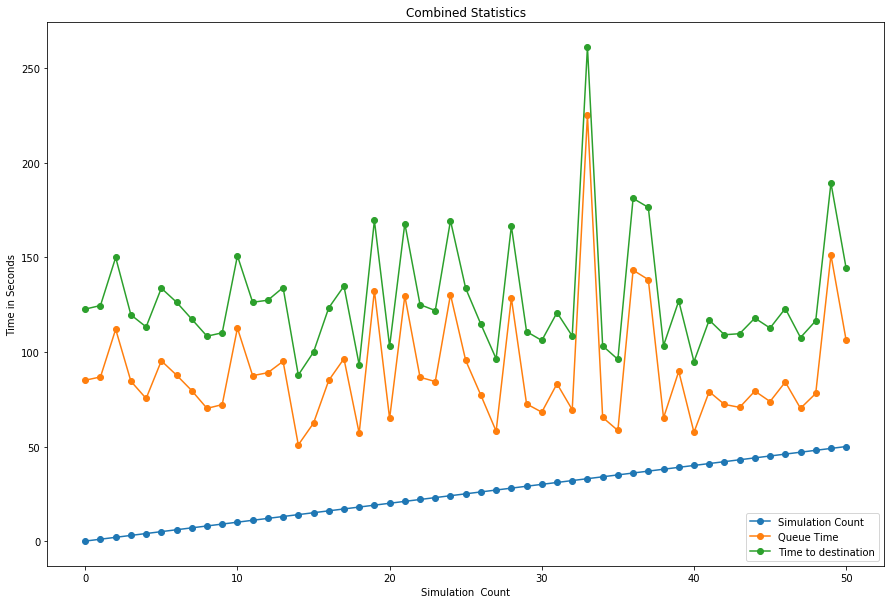

In [123]:
lines = df_marks.plot.line(figsize=(15,10),marker='o')

plt.title("Combined Statistics")
plt.xlabel('Simulation  Count')
plt.ylabel('Time in Seconds')

plt.legend(['Simulation Count','Queue Time ','Time to destination'], loc='lower right')

<h3>Conclusion</h3>